# SDGSat - Find Matching TIF-s

In [14]:
import rasterio
import geopandas as gpd
from dotenv import load_dotenv
from datetime import datetime

from conflict_monitoring_ntl.satellites import SDGSat
from geopandas.geodataframe import GeoDataFrame

In [15]:
_ = load_dotenv()

## Finding Matching TIF-s

In [16]:
gdf: GeoDataFrame = gpd.read_file("../data/shapes/lagos/lagos.shp")
date_range = [datetime(2024, 12, 22), datetime(2024, 12, 24)]

In [17]:
# gdf: GeoDataFrame = gpd.read_file("../data/shapes/zurich/zurich.shp")
# date_range = [datetime(2022, 3, 21), datetime(2022, 3, 23)]

In [18]:
sdgsat = SDGSat()

matching_files = sdgsat.get_matching_tiles(gdf, date_range)
matching_files

[PosixPath('/Users/jan.kokla/Documents/EPFL/conflict-monitoring-ntl/data/sdgsat/KX10_GIU_20241223_E3.08_N7.67_202400138080_L4A/KX10_GIU_20241223_E3.08_N7.67_202400138080_L4A_B_LH.tif')]

In [19]:
from rioxarray.merge import merge_arrays
from rasterio.windows import from_bounds
import rioxarray

# TODO: do it per date (merge per date)
# TODO: put it back to correct CRS
# TODO: make available picking a band

data_arrays = []

for matching_file in matching_files:

    with rasterio.open(matching_file) as src:

        # reproject shape geometry to SDGSAT CRS
        patch_bounds = gdf.to_crs(src.crs).total_bounds  # xmin, ymin, xmax, ymax

        # clip SDGSAT patch
        window = from_bounds(*patch_bounds, transform=src.transform)

        # extract offsets and dimensions (cast to int if needed)
        row_off = int(window.row_off)
        col_off = int(window.col_off)
        h = int(window.height)
        w = int(window.width)

        da = rioxarray.open_rasterio(src)

        # Suppose your top-left corner is at (col_off, row_off) and you want a window of (w, h)
        patch = da.isel(
            y=slice(row_off, row_off + h),
            x=slice(col_off, col_off + w)
        ).load()

        data_arrays.append(patch)


merged = merge_arrays(data_arrays)

In [20]:
merged.rio.crs.to_epsg()

32631

In [21]:
sdgsat_patch = merged[2].to_numpy()

In [22]:
sdgsat_patch.shape

(2219, 3019)

(np.float64(-0.5), np.float64(3018.5), np.float64(2218.5), np.float64(-0.5))

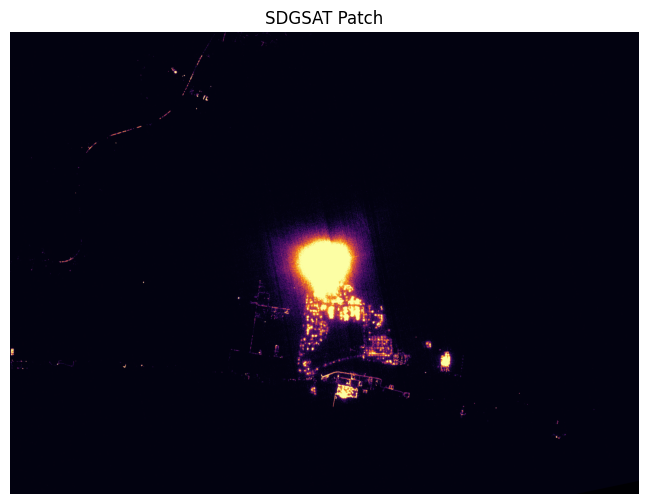

In [23]:
# Plot
from matplotlib import pyplot as plt
import numpy as np

fig, (ax1) = plt.subplots(1, 1, figsize=(14, 6))

valid_vals = sdgsat_patch[sdgsat_patch > 0]
vmax = np.percentile(valid_vals, 99) if valid_vals.size > 0 else 1

ax1.imshow(sdgsat_patch, cmap="inferno", vmin=0, vmax=vmax)
ax1.set_title("SDGSAT Patch")
ax1.axis("off")